In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
data_path = "C:/Users/Maria Lao/Documents/Universidad/UOC/TFM/3 - Datasets/WIFI/"
# data_path = "/kaggle/input/wifi-dataset-tfm/"



train_coords_file = data_path + "DSI1_trncrd.csv"
train_rss_file = data_path + "DSI1_trnrss.csv"
test_coords_file = data_path + "DSI1_tstcrd.csv"
test_rss_file = data_path + "DSI1_tstrss.csv"

In [2]:
# Load the files
train_coords = pd.read_csv(train_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
train_rss = pd.read_csv(train_rss_file, header=None)
test_coords = pd.read_csv(test_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
test_rss = pd.read_csv(test_rss_file, header=None)


In [3]:
# Initial exploration
print("Train Coordinates Shape:", train_coords.shape)
print("Train RSS Shape:", train_rss.shape)
print("Test Coordinates Shape:", test_coords.shape)
print("Test RSS Shape:", test_rss.shape)

Train Coordinates Shape: (1369, 5)
Train RSS Shape: (1369, 157)
Test Coordinates Shape: (348, 5)
Test RSS Shape: (348, 157)


In [4]:
# Count of unique points
unique_points_train = train_coords.drop_duplicates().shape[0]
unique_points_test = test_coords.drop_duplicates().shape[0]
print(f"Unique points in training set: {unique_points_train}")
print(f"Unique points in test set: {unique_points_test}")

Unique points in training set: 230
Unique points in test set: 348


In [5]:
# Count of samples by point

# Add an ID column to both DataFrames to ensure alignment
rss_count_per_point = train_coords.groupby(["x", "y", "z", "floor", "building"]).size()

# Display the counts
print(rss_count_per_point)

# Calculate the mean of RSS samples per point
mean_rss_per_point = rss_count_per_point.mean()

# Display the result
print(f"Mean RSS samples per point: {mean_rss_per_point:.2f}")

x          y          z    floor  building
0.093929   9.402937   3.7  1      1           6
1.269764   7.561457   3.7  1      1           6
1.472148   10.611660  3.7  1      1           6
2.667087   5.760037   3.7  1      1           6
2.667093   8.535582   3.7  1      1           6
                                             ..
89.530062  52.781808  3.7  1      1           6
90.411871  60.804807  3.7  1      1           6
90.507751  51.051983  3.7  1      1           6
91.904907  57.668375  3.7  1      1           6
93.013940  53.923820  3.7  1      1           6
Length: 230, dtype: int64
Mean RSS samples per point: 5.95


In [6]:
# Count unique building based on the 'identifier' column
unique_building_train = train_coords["building"].nunique()
unique_building_test = test_coords["building"].nunique()

print(f"Unique building in training set: {unique_building_train}")
print(f"Unique building in test set: {unique_building_test}")


Unique building in training set: 1
Unique building in test set: 1


In [7]:
# Count unique z based on the 'identifier' column
unique_z_train = train_coords["z"].nunique()
unique_z_test = test_coords["z"].nunique()

print(f"Unique z in training set: {unique_z_train}")
print(f"Unique z in test set: {unique_z_test}")

Unique z in training set: 1
Unique z in test set: 1


In [8]:
# Count unique floors based on the 'identifier' column
unique_floors_train = train_coords["floor"].nunique()
unique_floors_test = test_coords["floor"].nunique()

print(f"Unique floors in training set: {unique_floors_train}")
print(f"Unique floors in test set: {unique_floors_test}")

Unique floors in training set: 1
Unique floors in test set: 1


In [9]:
# 3. Detect NULL value - the most common value
# Combine both RSS sets for analysis
combined_rss = pd.concat([train_rss, test_rss], ignore_index=True)
null_value = combined_rss.stack().value_counts().idxmax()
print(f"Most common RSS value (potential NULL): {null_value}")

Most common RSS value (potential NULL): 100


In [10]:
# Calculate the percentage of values different from 100 in the dataset
total_values_train = train_rss.size
total_values_test = test_rss.size

# Count values different from 100
non_null_values_train = train_rss[train_rss != 100].count().sum()
non_null_values_test = test_rss[test_rss != 100].count().sum()

# Calculate the percentage of values different from 100
percentage_non_null_train = (non_null_values_train / total_values_train) * 100
percentage_non_null_test = (non_null_values_test / total_values_test) * 100

print(f"Percentage of values different from 100 in training set: {percentage_non_null_train:.2f}%")
print(f"Percentage of values different from 100 in test set: {percentage_non_null_test:.2f}%")

# Extract only the values different from 100 for statistical analysis
train_rss_filtered = train_rss[train_rss != 100].stack()
test_rss_filtered = test_rss[test_rss != 100].stack()

# Display descriptive statistics for values different from 100
print("\nTraining set RSS statistics (non-100 values):")
print(train_rss_filtered.describe())
print("\nTest set RSS statistics (non-100 values):")
print(test_rss_filtered.describe())


Percentage of values different from 100 in training set: 15.81%
Percentage of values different from 100 in test set: 15.05%

Training set RSS statistics (non-100 values):
count    33979.000000
mean       -78.770446
std         10.151544
min        -99.000000
25%        -86.000000
50%        -80.000000
75%        -73.000000
max        -35.000000
dtype: float64

Test set RSS statistics (non-100 values):
count    8223.000000
mean      -77.670072
std        10.147884
min       -97.000000
25%       -85.000000
50%       -79.000000
75%       -72.000000
max       -33.000000
dtype: float64


In [11]:
import numpy as np
import pandas as pd

# Ensure all rows have the same number of columns
def ensure_fixed_columns(df, num_columns, fill_value=100):
    """
    Ensures all rows in the DataFrame have the same number of columns by filling or trimming.
    """
    fixed_data = []
    for row in df.itertuples(index=False, name=None):  # Access rows as tuples
        row = list(row)
        if len(row) < num_columns:
            # Add fill_value to rows with fewer columns
            row.extend([fill_value] * (num_columns - len(row)))
        elif len(row) > num_columns:
            # Trim rows with extra columns
            row = row[:num_columns]
        fixed_data.append(row)
    # Convert the fixed data back into a DataFrame
    return pd.DataFrame(fixed_data)

# Define the expected number of columns
expected_columns = 157  # Replace with the actual number of columns required

# Process train_rss
train_rss = train_rss.fillna(100)  # Replace NaN with 100
train_rss_fixed = ensure_fixed_columns(train_rss, num_columns=expected_columns)

# Process test_rss
test_rss = test_rss.fillna(100)  # Replace NaN with 100
test_rss_fixed = ensure_fixed_columns(test_rss, num_columns=expected_columns)

# Verification
print(f"Train dataset shape: {train_rss_fixed.shape}")
print(f"Test dataset shape: {test_rss_fixed.shape}")




Train dataset shape: (1369, 157)
Test dataset shape: (348, 157)


In [12]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, null_value=100):
    """
    Detects outliers in RSS data using the Interquartile Range (IQR) method.

    Parameters:
        data (DataFrame): DataFrame with RSS values for each AP.
        null_value (int): Value representing null RSS measurements (default: 100).

    Returns:
        DataFrame: A DataFrame with the same shape as input, where outliers are marked as True.
    """
    # Replace null values with NaN for processing
    data = data.replace(null_value, np.nan)

    # Calculate Q1, Q3, and IQR for each column (AP)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = (data < lower_bound) | (data > upper_bound)

    return outliers

# Detect outliers in RSS data
outliers = detect_outliers_iqr(train_rss)
print("Summary of Outliers by AP:")
print(outliers.sum())

Summary of Outliers by AP:
0      30
1       0
2       0
3       0
4       0
       ..
152     0
153     0
154     0
155     0
156     0
Length: 157, dtype: int64


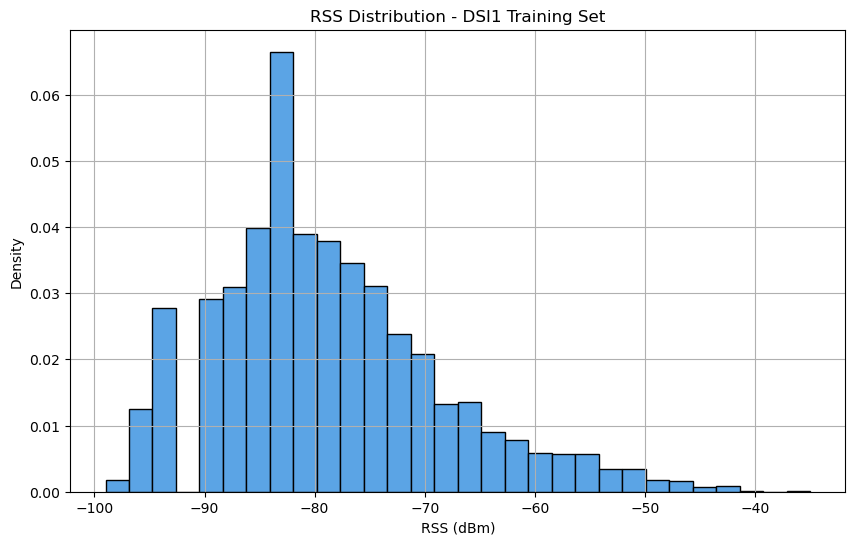

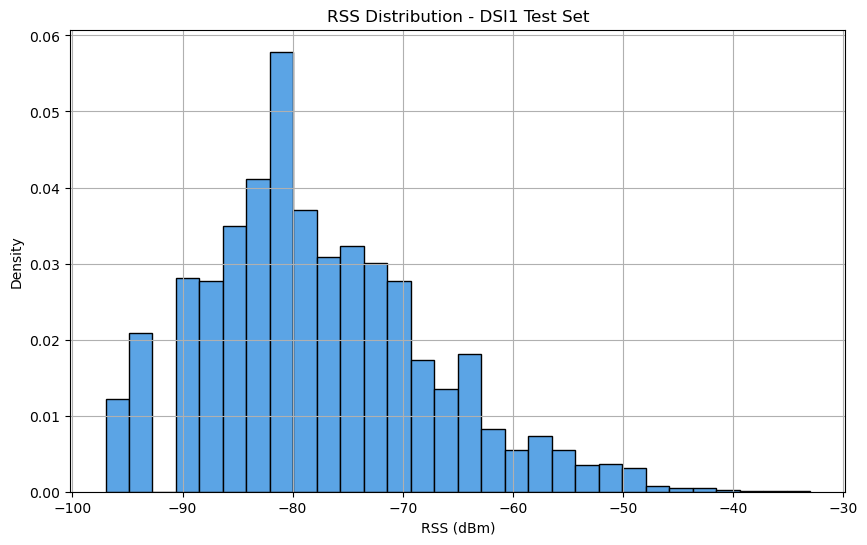

In [13]:
# Function to plot RSS distribution for each dataset, filtered to ignore values of 100
def plot_rss_distribution(data, title, dataset_name):
    # Flatten the data and filter out values equal to 100
    data_stack = data[data != 100].stack().reset_index(drop=True)  # Convert to a flat series with a reset index
    
    # Plot the histogram if there are valid RSS values
    if not data_stack.empty:
        plt.figure(figsize=(10, 6))
        plt.hist(data_stack, bins=30, edgecolor='black', density=True, color='#5ba4e5')  # Light pastel blue
        plt.title(f"RSS Distribution - {dataset_name} {title}")
        plt.xlabel("RSS (dBm)")
        plt.ylabel("Density")
        plt.grid(True)  # Activate grid
        plt.show()
    else:
        print(f"No valid RSS values found for {title}")

# Call the function for both training and test sets with dataset names
plot_rss_distribution(train_rss, "Training Set", "DSI1")
plot_rss_distribution(test_rss, "Test Set", "DSI1")



La distribución de los valores RSS en ambas gráficas muestra una forma asimétrica hacia la izquierda, con una concentración de valores en torno a los -80 dBm. Aquí tienes algunos puntos destacados:

1. **Moda alrededor de -80 dBm**: Ambas distribuciones tienen un pico alrededor de -80 dBm, lo que podría indicar que la mayoría de los puntos de acceso captan la señal en este nivel o en uno similar, lo cual es común en entornos de interior donde los valores de RSS suelen estar en ese rango debido a la atenuación por paredes y otros obstáculos.

2. **Rango de valores**: La mayor parte de los datos está entre -100 dBm y -40 dBm, lo cual es consistente con señales de Wi-Fi en entornos reales, donde los valores más altos (-50 dBm a -40 dBm) representan áreas más cercanas a los puntos de acceso, y los valores más bajos (-100 dBm a -80 dBm) reflejan áreas de mayor distancia o con obstáculos significativos.

3. **Caída rápida después de -80 dBm**: La caída a la derecha del pico sugiere que hay menos muestras con niveles de señal más fuertes (por encima de -70 dBm). Esto podría implicar que la mayoría de las muestras se capturaron a una distancia moderada de los puntos de acceso o que los entornos en los que se recolectaron los datos tienen varias barreras, lo que dificulta la recepción de señales más intensas.

4. **Consistencia entre conjunto de entrenamiento y prueba**: La forma de ambas distribuciones es similar, lo cual es positivo, ya que indica que los datos de prueba y de entrenamiento fueron tomados en condiciones similares, y eso suele mejorar la precisión de los modelos que puedas entrenar con ellos.

5. **Densidad y ruido**: La densidad alrededor de -80 dBm sugiere que este es el nivel de señal más común. Si bien puede representar el valor de una señal real, es importante asegurarse de que no se trata de un valor fijo o “estático” introducido por el hardware o software del equipo, especialmente si notas que es un valor muy dominante en múltiples ubicaciones.

En general, estas distribuciones son bastante típicas de escenarios de Wi-Fi Fingerprinting en interiores. Si tienes alguna sospecha sobre la presencia de ruido o valores que podrían no representar correctamente la señal, podríamos hacer un análisis adicional de outliers o comparar estas distribuciones entre diferentes ubicaciones o pisos.

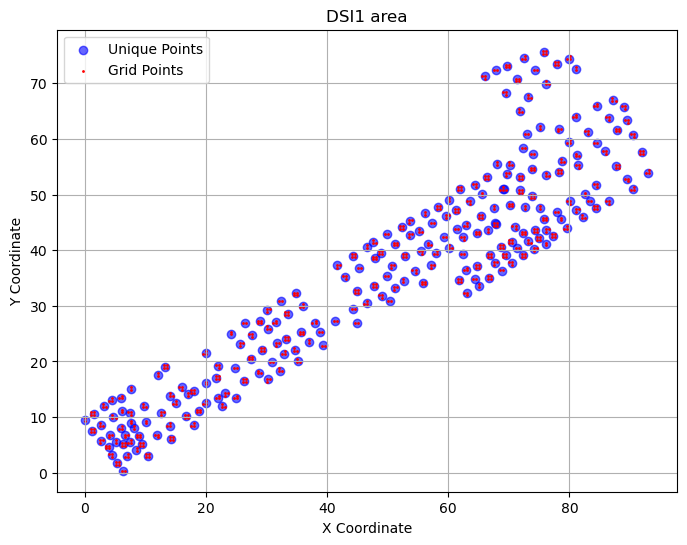

Estimated Area Covered: 173.00 m²


In [19]:
# Area covered in the datasets

from scipy.spatial import cKDTree
# Extract x and y coordinates
x = train_coords["x"]
y = train_coords["y"]

points = np.array(list(zip(x, y)))

# Remove duplicate points to optimize calculations
unique_points = np.unique(points, axis=0)

# Create a grid based on the range of the unique points
x_min, x_max = unique_points[:, 0].min(), unique_points[:, 0].max()
y_min, y_max = unique_points[:, 1].min(), unique_points[:, 1].max()

# Define grid resolution
resolution = 0.5  # Adjust the cell size for finer or coarser resolution

# Generate grid points
x_grid, y_grid = np.meshgrid(
    np.arange(x_min, x_max + resolution, resolution),
    np.arange(y_min, y_max + resolution, resolution)
)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Use KDTree for efficient point queries
tree = cKDTree(unique_points)
distances, _ = tree.query(grid_points, distance_upper_bound=resolution)

# Only include grid points within the specified resolution of the original points
within_points = distances != np.inf

# Calculate the estimated area
area_estimated = within_points.sum() * resolution**2

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(unique_points[:, 0], unique_points[:, 1], alpha=0.6, label="Unique Points", color="blue")
plt.scatter(grid_points[within_points][:, 0], grid_points[within_points][:, 1], 
            s=1, color="red", label="Grid Points")
plt.title("DSI1 area")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated Area Covered: {area_estimated:.2f} m²")


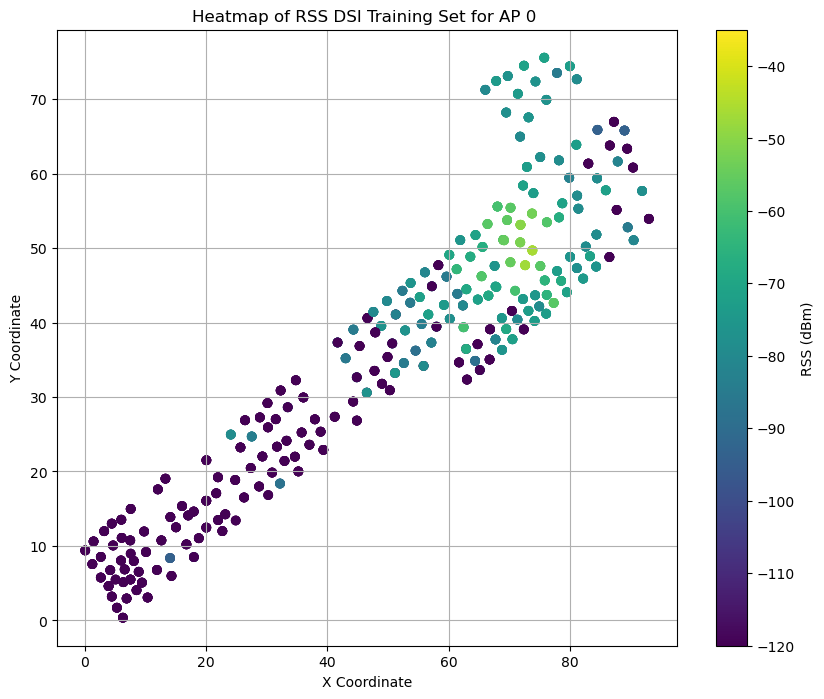

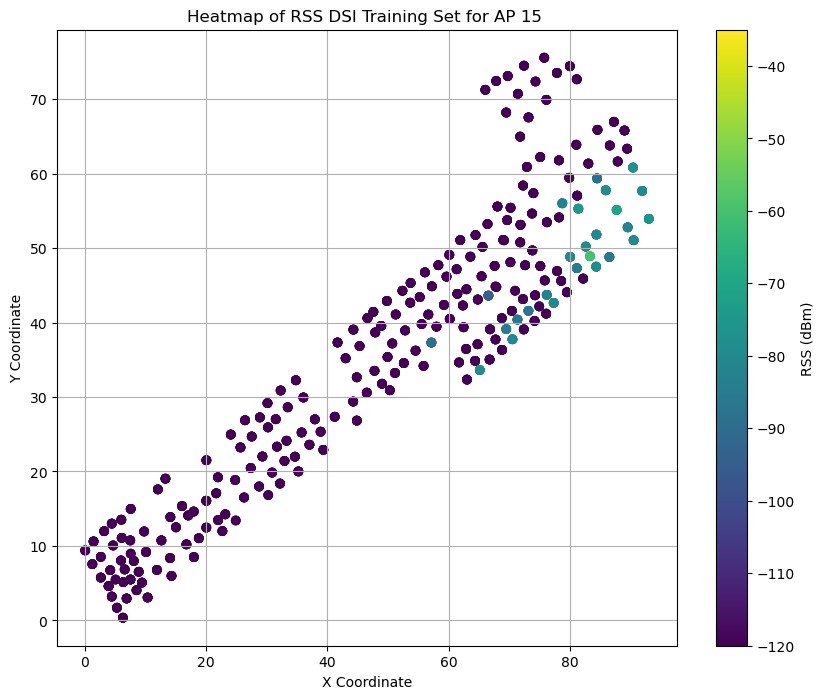

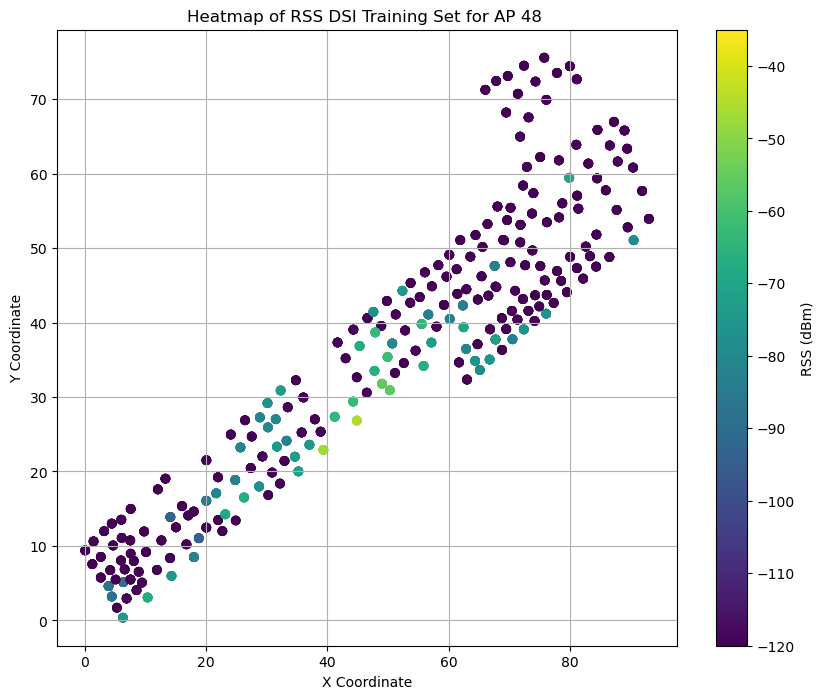

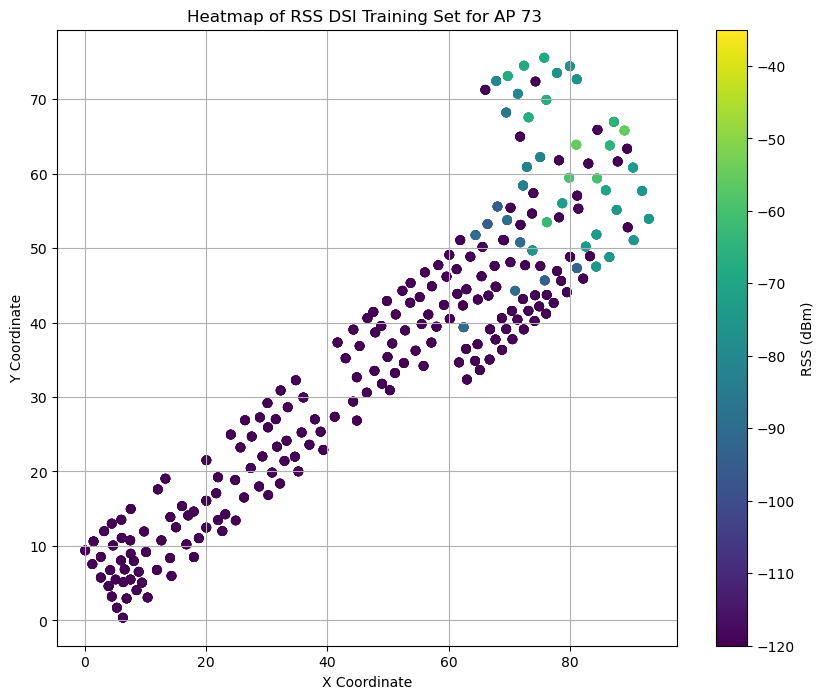

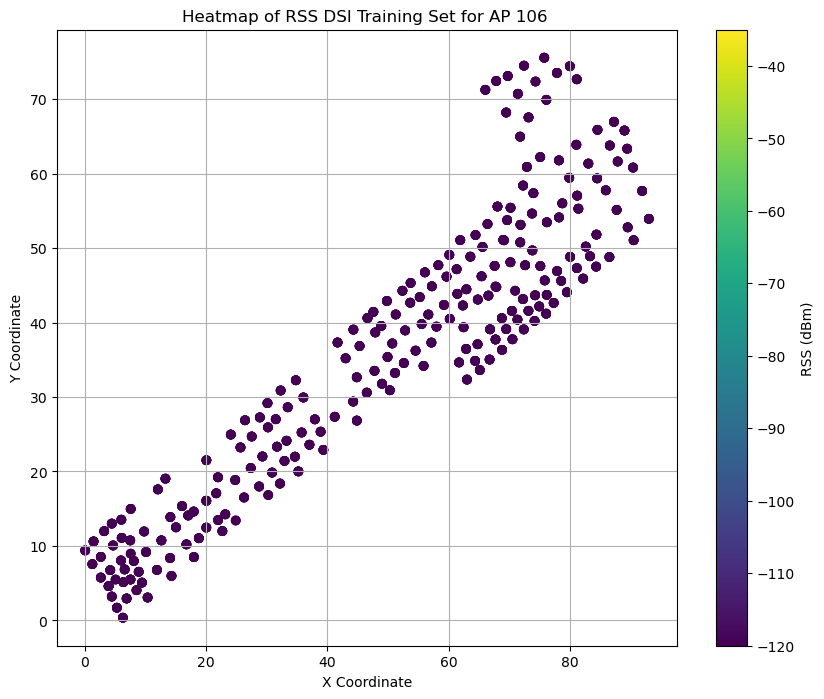

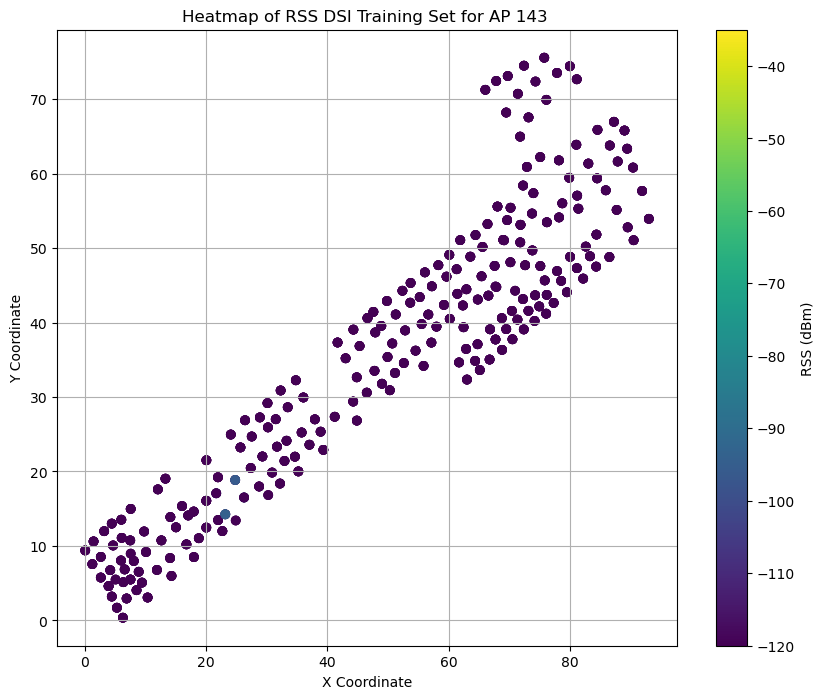

In [20]:
# Function to plot a heatmap for a specific AP

def plot_rss_heatmap(coords, rss, ap_index, title, null_value=100):
    """
    Plots a heatmap where color intensity represents the RSS value for a specific AP.

    Parameters:
        coords (DataFrame): DataFrame with coordinates (x, y).
        rss (DataFrame): DataFrame with RSS values for each AP.
        ap_index (int): Index of the AP to plot.
        title (str): Title of the plot.
        null_value (int): Value representing null RSS measurements (default: 100).
    """
    # Extract the AP's RSS values and replace null values with -120
    ap_rss = rss.iloc[:, ap_index].replace(null_value, -120)

    # Calculate RSS_MIN and RSS_MAX dynamically based on the dataset
    rss_min = rss.replace(null_value, -120).min().min()  # Minimum valid RSS value
    rss_max = rss.replace(null_value, -120).max().max()  # Maximum valid RSS value

    # Extract coordinates and RSS values
    x = coords["x"]
    y = coords["y"]
    rss_values = ap_rss

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x, y, c=rss_values, cmap="viridis", vmin=rss_min, vmax=rss_max)
    plt.colorbar(scatter, label="RSS (dBm)")
    plt.title(f"Heatmap of RSS {title} for AP {ap_index} ")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()


# Select AP indices to plot
ap_indices = [0, 15, 48, 73, 106, 143] 
for ap_index in ap_indices:
    plot_rss_heatmap(train_coords, train_rss, ap_index, title=f"DSI Training Set")


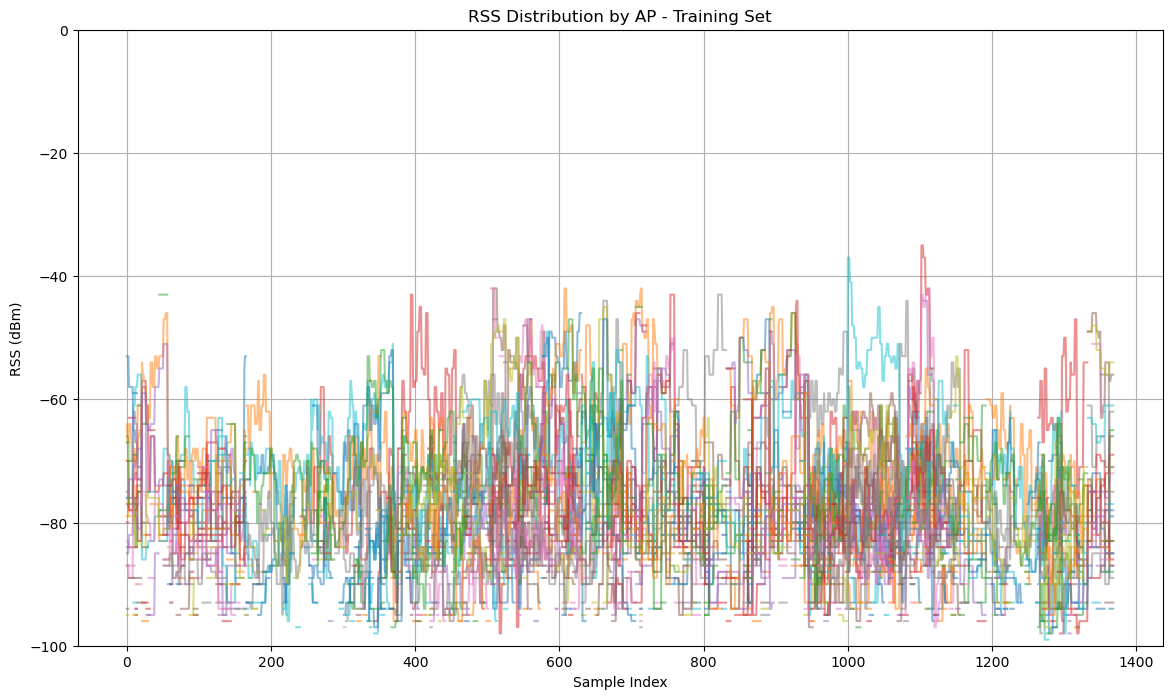

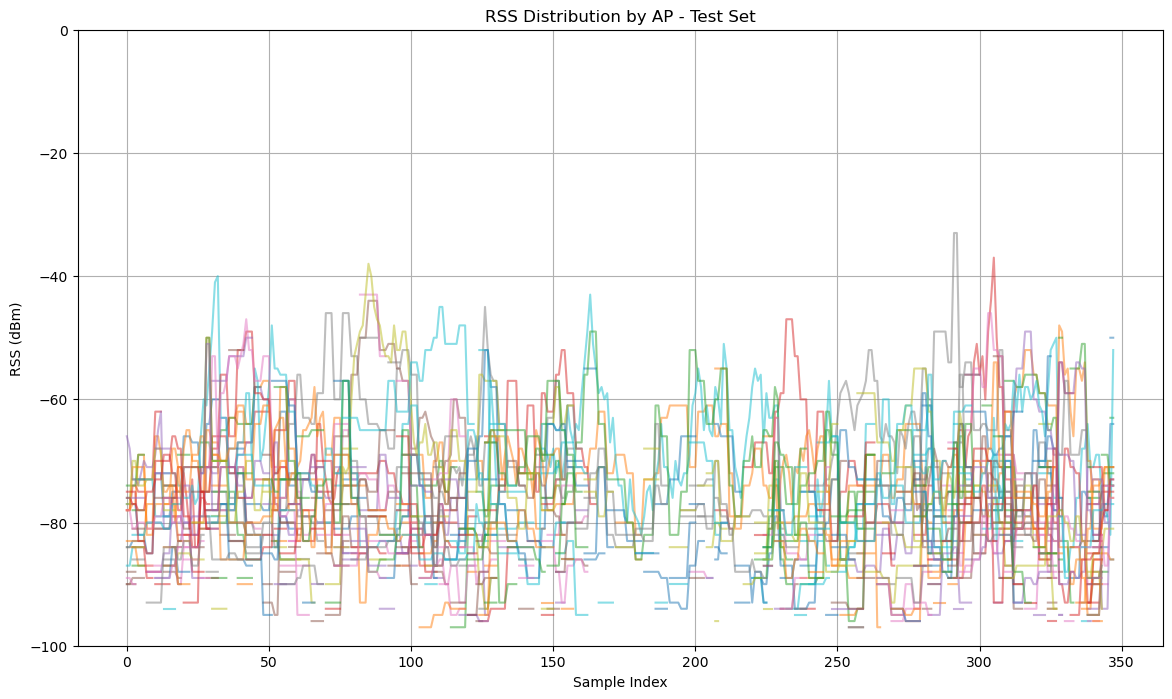

In [16]:
# RSS Distribution by AP

# Function to plot RSS distribution by AP with each AP as a line
def plot_rss_distribution_by_ap(data, title, null_value=100):
    # Filter out the null values (100) for analysis
    data_filtered = data[data != null_value]
    
    # Plot each AP as a line in the same figure
    plt.figure(figsize=(14, 8))
    for column in data_filtered.columns:
        plt.plot(data_filtered.index, data_filtered[column], alpha=0.5)  # Alpha for transparency

    plt.title(f"RSS Distribution by AP - {title}")
    plt.xlabel("Sample Index")
    plt.ylabel("RSS (dBm)")
    plt.ylim(-100, 0)  # Typical range for RSS in dBm
    plt.grid(True)
    plt.show()

# Plot for both training and test sets
plot_rss_distribution_by_ap(train_rss, "Training Set")
plot_rss_distribution_by_ap(test_rss, "Test Set")

In [17]:
# 6. Additional analysis (if you want to go deeper)
# Example: RSS by specific point, descriptive statistics, etc.

# Example: descriptive statistics of the RSS data
print("Training RSS Descriptive Statistics:")
print(train_rss.replace(null_value, np.nan).describe())
print("Test RSS Descriptive Statistics:")
print(test_rss.replace(null_value, np.nan).describe())

Training RSS Descriptive Statistics:
              0           1          2          3     4           5    \
count  707.000000  375.000000   9.000000  18.000000   4.0  161.000000   
mean   -73.630835  -72.570667 -81.666667 -65.722222 -94.0  -79.857143   
std     10.275845    8.889078   8.500000   5.919117   0.0    4.397239   
min    -94.000000  -96.000000 -93.000000 -71.000000 -94.0  -86.000000   
25%    -80.000000  -78.500000 -93.000000 -70.000000 -94.0  -84.000000   
50%    -76.000000  -73.000000 -76.000000 -69.000000 -94.0  -80.000000   
75%    -69.000000  -66.000000 -76.000000 -58.000000 -94.0  -76.000000   
max    -46.000000  -48.000000 -76.000000 -56.000000 -94.0  -72.000000   

              6           7         8     9    ...         147         148  \
count  190.000000  216.000000  80.00000   5.0  ...  636.000000  249.000000   
mean   -77.989474  -80.078704 -80.67500 -94.0  ...  -86.968553  -80.574297   
std      4.437681    4.177271   3.91613   0.0  ...    4.270642    6.963

In [18]:
# Function to identify columns with all values equal to null_value in both datasets
def find_common_constant_columns(train_data, test_data, null_value=100):
    """
    Identifies columns where all values are equal to null_value in both train and test datasets.
    
    Parameters:
    - train_data: DataFrame for training RSS data.
    - test_data: DataFrame for test RSS data.
    - null_value: Value representing no signal (default: 100).
    
    Returns:
    - List of column indices that are constant in both datasets.
    """
    # Identify constant columns in train and test datasets separately
    train_constant_columns = train_data.columns[(train_data == null_value).all()]
    test_constant_columns = test_data.columns[(test_data == null_value).all()]
    
    # Find the intersection of constant columns in both datasets
    common_constant_columns = train_constant_columns.intersection(test_constant_columns)
    
    return common_constant_columns.tolist()


# Function to remove specified columns from both datasets
def remove_columns_from_datasets(train_data, test_data, columns_to_remove):
    """
    Removes the specified columns from both train and test datasets.
    
    Parameters:
    - train_data: DataFrame for training RSS data.
    - test_data: DataFrame for test RSS data.
    - columns_to_remove: List of column indices to remove.
    
    Returns:
    - Filtered train and test datasets.
    """
    train_filtered = train_data.drop(columns=columns_to_remove)
    test_filtered = test_data.drop(columns=columns_to_remove)
    return train_filtered, test_filtered


# Step 1: Find common constant columns
common_constant_columns = find_common_constant_columns(train_rss, test_rss)

# Step 2: Remove these columns from both datasets
train_rss_filtered, test_rss_filtered = remove_columns_from_datasets(train_rss, test_rss, common_constant_columns)

# Step 3: Print results
print(f"Removed {len(common_constant_columns)} common constant columns")

print("Train RSS Shape:", train_rss_filtered.shape)
print("Test RSS Shape:", test_rss_filtered.shape)

# Paths for saving the cleaned data
train_clean_file = data_path + "DSI1_trnrss_clean.csv"
test_clean_file = data_path + "DSI1_tstrss_clean.csv"

# Save the cleaned datasets to CSV without headers
train_rss_filtered.to_csv(train_clean_file, index=False, header=False)
test_rss_filtered.to_csv(test_clean_file, index=False, header=False)


Removed 0 common constant columns
Train RSS Shape: (1369, 157)
Test RSS Shape: (348, 157)
